In [1]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from MVAE import *
import cv2 

In [2]:
device = torch.device(1 if torch.cuda.is_available() else 0)
device

device(type='cuda', index=1)

In [117]:
dataSetDIR = f"D:\_0Luciano\_0PHD\datasets"
masksDir =  f'D:\_0Luciano\_0PHD\datasets\masks10-90'


TRAIN_MASK_DIR = './train/'
TRAIN_CSV = f'D:/_0Luciano/_0PHD/datasets/tgs-salt/train1090.csv'    #./train/train.csv'
DEPTH_CSV = 'depths.csv'

TRAIN_DIR  = 'D:/_0Luciano/_0PHD/datasets/tgs-salt/'
TRAIN_IMAGE_DIR = 'D:/_0Luciano/_0PHD/datasets/tgs-salt/train/images/'
TRAIN_MASK_DIR  = 'D:/_0Luciano/_0PHD/datasets/tgs-salt/train/masks/'
TEST_IMAGE_DIR  = 'D:/_0Luciano_0PHD/datasets/tgs-salt/test/images/'



# Alternate Custom DataSet

In [4]:
import skimage.measure as skm
import pandas as pd
from PIL import Image
import os
import cv2 

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels.iloc[idx, 0] + '.png'
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [118]:
transform = transforms.Compose([transforms.Resize((64 , 64)),
                                transforms.Grayscale(num_output_channels=1)
                                ,transforms.ToTensor()])
masksDS = CustomImageDataset(TRAIN_CSV,TRAIN_MASK_DIR,transform)

In [105]:
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

In [149]:
transformOut = transforms.Compose([transforms.Resize((101 , 101)),
                                    transforms.GaussianBlur((7, 7), sigma=(0.1, 2.0)),
                                   ThresholdTransform(thr_255=127)
                                  ])

In [132]:
dataloaderCustomDS = DataLoader(masksDS, batch_size=64, shuffle=True)

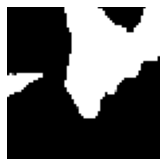

In [120]:
tensorImg = masksDS[6][0]
numpyImg = tensorImg.numpy()[0]
#Pooling = skimage.measure.block_reduce(numpyImg, (2,2), np.max) 
plt.figure()
plt.subplot(1, 2, 1); plt.imshow(numpyImg,  cmap='gray');  plt.axis('off')
#plt.subplot(1, 2, 2); plt.imshow(mPooling,cmap = 'gray' ); plt.axis('off')
plt.show()

torch.Size([64, 1, 64, 64])


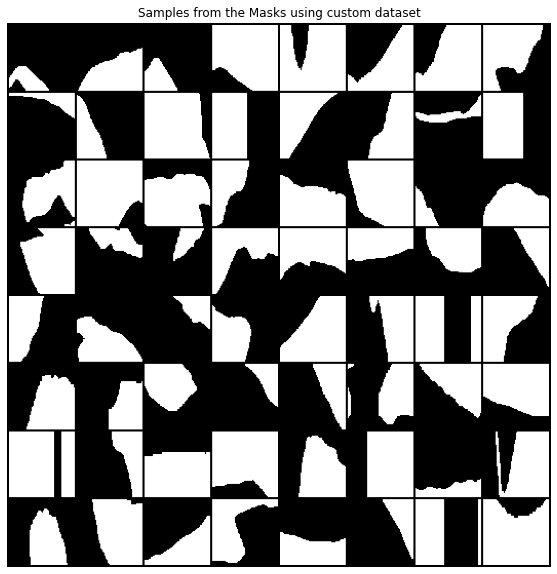

In [121]:
it=iter(dataloaderCustomDS)
real_batch = next(iter(it))
plt.figure(figsize=(10,10))
print(real_batch[0].size())
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)),cmap='gray')
plt.axis('off')
plt.title('Samples from the Masks using custom dataset');
plt.show()

# Treinamento

In [122]:
Decoders = nn.ModuleList([Decoder_MLP(latent_dim=100, in_channel=1, im_size=64, hiddens=[256, 512, 1024])])
MabVae = MabVAE(dataloaderCustomDS, Decoders, eps=0.3, i=0)
trainer = Trainer(gpus=1, max_epochs=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [123]:
trainer.fit(MabVae)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | decoders | ModuleList | 4.9 M 
1 | encoder  | Encoder    | 8.0 M 
----------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.653    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 26/26 [00:09<00:00,  2.83it/s, loss=2.42e+06, v_num=1]


In [124]:
MabVae.NbDraws/torch.sum(MabVae.NbDraws)

tensor([1.], device='cuda:0')

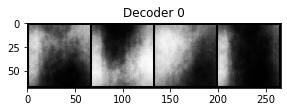

In [150]:
fixed_noise=torch.randn(4,100)
plt.figure(figsize=(10,10))
for i,decoder in enumerate(Decoders):
  fake=decoder(fixed_noise).detach()
  plt.subplot(3,2,i+1)
  plt.title(f'Decoder {i}')
  plt.imshow(np.transpose(utils.make_grid(fake,padding=2,normalize=True).cpu(),(1,2,0)))

plt.savefig(f'Decoders_MASK.png')

In [151]:
blurredAndBinarizedTensorImages = transformOut(fake)

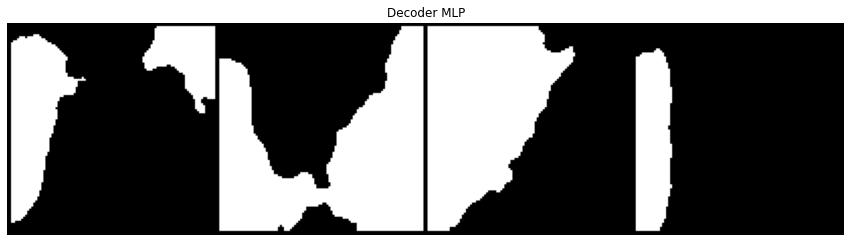

In [152]:
plt.figure(figsize=(15,15))
plt.title(f'Decoder MLP')
plt.axis('off')
plt.imshow(np.transpose(utils.make_grid(blurredAndBinarizedTensorImages,padding=2,normalize=True).cpu(),(1,2,0)))

In [160]:
img = fake[0]
blurred = img.numpy()[0]
u8blurred = blurred*255
u8blurred = u8blurred.astype(np.uint8)
u8blurred

array([[104, 112, 100, ..., 175, 184, 180],
       [105, 113, 127, ..., 185, 176, 168],
       [123, 121, 132, ..., 177, 183, 175],
       ...,
       [129, 129, 122, ...,  25,  21,  22],
       [119, 111, 114, ...,  22,  20,  21],
       [105,  99, 108, ...,  20,  18,  19]], dtype=uint8)

In [161]:
(thresh, im_bw) = cv2.threshold(u8blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


In [167]:
cv2.imshow("Threshold:", im_bw)

: 

In [165]:
# apply Otsu's automatic thresholding which automatically determines
# the best threshold value
(T, threshInv) = cv2.threshold(blurred, 0, 255,	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
cv2.imshow( threshInv)

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-u4kjpz2z\opencv\modules\imgproc\src\thresh.cpp:1557: error: (-2:Unspecified error) in function 'double __cdecl cv::threshold(const class cv::_InputArray &,const class cv::_OutputArray &,double,double,int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 5 (CV_32FC1)


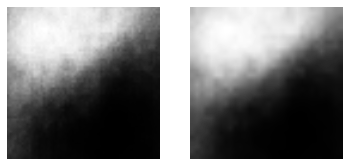

In [139]:
img = fake[0]
npyImg = img.numpy()[0]
mPooling = skm.block_reduce(npyImg, (2,2), np.max) 
fig, ax = plt.subplots(1, 2)
ax[0].axis('off')
ax[0].imshow(npyImg, interpolation='bilinear', cmap= 'gray' );  
ax[1].imshow(mPooling,  interpolation='bilinear', cmap='gray'); 
ax[1].axis('off')
plt.show()

(-0.5, 529.5, 529.5, -0.5)

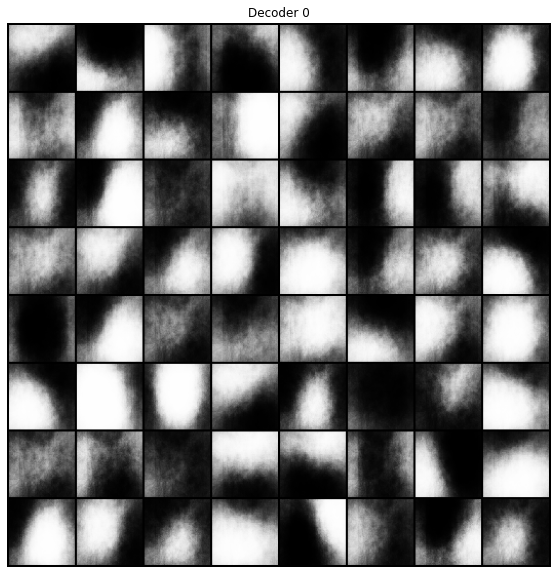

In [134]:
samples = 64
MLP= Decoders[0]
fixed_noise=torch.randn(samples,100)

plt.figure(figsize=(10,10))
fake=MLP(fixed_noise).detach()
plt.title(f'Decoder {i}')
plt.imshow(np.transpose(utils.make_grid(fake,padding=2,normalize=True).cpu(),(1,2,0)))
plt.axis('off')

(-0.5, 529.5, 529.5, -0.5)

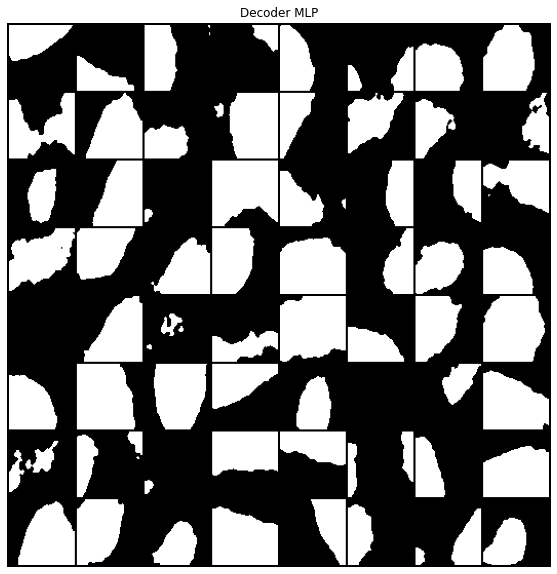

In [138]:
blurredAndBinarizedTensorImages = transformOut(fake)
plt.figure(figsize=(10,10))
plt.title(f'Decoder MLP')
plt.imshow(np.transpose(utils.make_grid(blurredAndBinarizedTensorImages,padding=2,normalize=True).cpu(),(1,2,0)))
plt.axis('off')

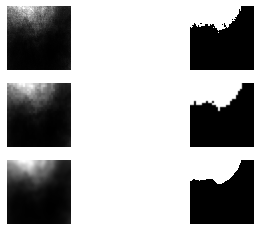

In [35]:
# BEST threshold method to mask => gaussian
thresh = 0.1

predictImg = fake[0].numpy()[0]

npyImg = predictImg
npyImg_bw       = cv2.threshold(npyImg, thresh, 255, cv2.THRESH_BINARY)[1]

pooled = skm.block_reduce(npyImg, (2,2), np.max) 
pooled_bw = cv2.threshold(pooled, thresh, 255, cv2.THRESH_BINARY)[1]

blurred = cv2.GaussianBlur(npyImg, (7, 7), 0)
blurred_bw       = cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY)[1]

images=(npyImg,npyImg_bw,pooled,pooled_bw,blurred,blurred_bw)
imagesEnum = enumerate(images)

linhas=3
fig, ax = plt.subplots(linhas, 2 ) #,figsize=(10,10))
for i,img in imagesEnum:
    ax[int(i/2),i%2].axis('off')
    ax[int(i/2),i%2].imshow(img, cmap= 'gray' ); 
plt.show()